# Final Project for Data Analytics

## What is an optimal location to open a restaurant in the city of Toronto?

### Yikun Liu yl4299

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import json
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
import time

## Geographical Info of Neighborhoods in Toronto

### Script data from Wikipedia page

In [2]:
# script the html page
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
response = requests.get(url)
if response.status_code == 200:
    soup = BeautifulSoup(response.content,'lxml')

In [3]:
# get the PostalCode and Borough and save to lists
l = []
PostalCode = []
Borough = []
for tag in soup.find('table').find_all('td'):
    l.append(tag.get_text())
for i in range(len(l)):
    if i%3==0:
        PostalCode.append(l[i].strip())
    elif i%3==1:
        Borough.append(l[i].strip())

In [4]:
# create a dataframe and put the data above into it
df = pd.DataFrame(columns = ['PostalCode','Borough'])
df.PostalCode = PostalCode
df.Borough = Borough

In [5]:
# remove rows that contain unassigned boroughs
df = df[df.Borough != 'Not assigned'].reset_index(drop = True)

In [6]:
df.head()

,PostalCode,Borough
0,M3A,North York
1,M4A,North York
2,M5A,Downtown Toronto
3,M6A,North York
4,M7A,Downtown Toronto


In [7]:
df.shape

(103, 2)

### Add coordinates

In [8]:
coor = pd.read_csv('Geospatial_Coordinates.csv')

In [9]:
df = df.merge(coor, left_on = 'PostalCode', right_on = 'Postal Code', how = 'left')
df = df.drop('Postal Code',1)

In [10]:
df

,PostalCode,Borough,Latitude,Longitude
0,M3A,North York,43.753259,-79.329656
1,M4A,North York,43.725882,-79.315572
2,M5A,Downtown Toronto,43.654260,-79.360636
3,M6A,North York,43.718518,-79.464763
4,M7A,Downtown Toronto,43.662301,-79.389494
...,...,...,...,...
98,M8X,Etobicoke,43.653654,-79.506944
99,M4Y,Downtown Toronto,43.665860,-79.383160
100,M7Y,East Toronto,43.662744,-79.321558
101,M8Y,Etobicoke,43.636258,-79.498509


## Explore Existing Restaurants around Each Neighborhood

### Get venues info around each postal code

In [11]:
# Using Foursqaure API
CLIENT_ID = '3GSOCBER1WPKAWDHRZWW2FAYTTMQZT2OVZGXVEJOTY1Y4DTJ'
CLIENT_SECRET = 'SFZU24TJPXDXBFNDEW0K0BMHSBVNS2DA0Q50DCMKBKDHFO1F'
VERSION = '20180605'


def getNearbyVenues(postcodes, latitudes, longitudes, radius=2000, LIMIT = 50):
    
    venues_list=[]
      
    for pc, lat, lng in zip(postcodes, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        
        results = requests.get(url).json()
        
        # There might be sometimes when the Foursquare API is not stable
        while results['meta']['code']!=200: 
            # Wait for 3 seconds
            time.sleep(3)
            results = requests.get(url).json()

        results = results["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            pc, 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode','Venue Category']
    
    return(nearby_venues)

In [12]:
venues = getNearbyVenues(postcodes=df['PostalCode'],latitudes=df['Latitude'],longitudes=df['Longitude'])

In [13]:
venues

,PostalCode,Venue Category
0,M3A,Caribbean Restaurant
1,M3A,Golf Course
2,M3A,Park
3,M3A,Caribbean Restaurant
4,M3A,Supermarket
...,...,...
4977,M8Z,Fish Market
4978,M8Z,Gas Station
4979,M8Z,Coffee Shop
4980,M8Z,Fast Food Restaurant


### Extract the restaurant types

In [14]:
venues_extract = venues.copy()
for i in range(len(venues_extract)):
    if 'Restaurant' not in venues_extract['Venue Category'][i]:
        venues_extract = venues_extract[venues_extract.index != i]
venues_extract = venues_extract.reset_index(drop = True)
venues_extract.head()

,PostalCode,Venue Category
0,M3A,Caribbean Restaurant
1,M3A,Caribbean Restaurant
2,M3A,Seafood Restaurant
3,M3A,Mediterranean Restaurant
4,M3A,Asian Restaurant


### Numbers and diversity of restaurants nearby

In [15]:
res_count = venues_extract.groupby('PostalCode').size().reset_index()
res_count.columns = ['PostalCode','Restaurant Counts']
res_count

,PostalCode,Restaurant Counts
0,M1B,8
1,M1C,4
2,M1E,6
3,M1G,11
4,M1H,13
...,...,...
97,M9N,6
98,M9P,5
99,M9R,10
100,M9V,12


In [16]:
res_div = venues_extract.groupby('PostalCode')['Venue Category'].unique().reset_index()
res_div.columns = ['PostalCode','Restaurant Diversity']
for i in range(len(res_div)):
    res_div['Restaurant Diversity'][i] = len(res_div['Restaurant Diversity'][i])
res_div

,PostalCode,Restaurant Diversity
0,M1B,4
1,M1C,4
2,M1E,5
3,M1G,7
4,M1H,10
...,...,...
97,M9N,5
98,M9P,4
99,M9R,6
100,M9V,5


In [17]:
res = res_count.merge(res_div,on = 'PostalCode')
res = res.merge(df,on = 'PostalCode')
res

,PostalCode,Restaurant Counts,Restaurant Diversity,Borough,Latitude,Longitude
0,M1B,8,4,Scarborough,43.806686,-79.194353
1,M1C,4,4,Scarborough,43.784535,-79.160497
2,M1E,6,5,Scarborough,43.763573,-79.188711
3,M1G,11,7,Scarborough,43.770992,-79.216917
4,M1H,13,10,Scarborough,43.773136,-79.239476
...,...,...,...,...,...,...
97,M9N,6,5,York,43.706876,-79.518188
98,M9P,5,4,Etobicoke,43.696319,-79.532242
99,M9R,10,6,Etobicoke,43.688905,-79.554724
100,M9V,12,5,Etobicoke,43.739416,-79.588437


### Add dummy variable to see if the neighborhood is downtown

In [18]:
Downtown = np.where(res['Borough'] == 'Downtown Toronto',1,0)
res['Downtown'] = Downtown
res

,PostalCode,Restaurant Counts,Restaurant Diversity,Borough,Latitude,Longitude,Downtown
0,M1B,8,4,Scarborough,43.806686,-79.194353,0
1,M1C,4,4,Scarborough,43.784535,-79.160497,0
2,M1E,6,5,Scarborough,43.763573,-79.188711,0
3,M1G,11,7,Scarborough,43.770992,-79.216917,0
4,M1H,13,10,Scarborough,43.773136,-79.239476,0
...,...,...,...,...,...,...,...
97,M9N,6,5,York,43.706876,-79.518188,0
98,M9P,5,4,Etobicoke,43.696319,-79.532242,0
99,M9R,10,6,Etobicoke,43.688905,-79.554724,0
100,M9V,12,5,Etobicoke,43.739416,-79.588437,0


## Cluster Neighborhoods

In [19]:
res_clustering = res.drop(['PostalCode','Borough','Latitude','Longitude'],1)
res_clustering = StandardScaler().fit_transform(res_clustering)

### Select the number of clusters with elbow method

In [20]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 

K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(res_clustering)     
    distortions.append(sum(np.min(cdist(res_clustering, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / res_clustering.shape[0]) 
    mapping1[k] = sum(np.min(cdist(res_clustering, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / res_clustering.shape[0] 
    inertias.append(kmeanModel.inertia_) 
    mapping2[k] = kmeanModel.inertia_ 

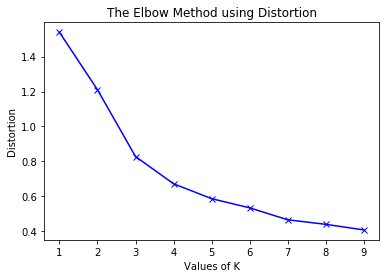

In [21]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

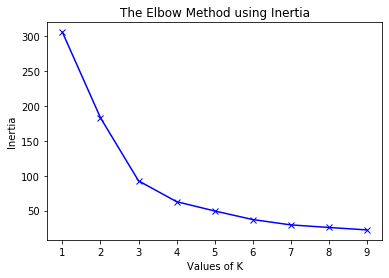

In [22]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

In [23]:
# run k-mean clustering
k = 4
db = KMeans(n_clusters=k,random_state = 0).fit(res_clustering)

In [24]:
res['Cluster'] = db.labels_ 
res

,PostalCode,Restaurant Counts,Restaurant Diversity,Borough,Latitude,Longitude,Downtown,Cluster
0,M1B,8,4,Scarborough,43.806686,-79.194353,0,3
1,M1C,4,4,Scarborough,43.784535,-79.160497,0,3
2,M1E,6,5,Scarborough,43.763573,-79.188711,0,3
3,M1G,11,7,Scarborough,43.770992,-79.216917,0,0
4,M1H,13,10,Scarborough,43.773136,-79.239476,0,0
...,...,...,...,...,...,...,...,...
97,M9N,6,5,York,43.706876,-79.518188,0,3
98,M9P,5,4,Etobicoke,43.696319,-79.532242,0,3
99,M9R,10,6,Etobicoke,43.688905,-79.554724,0,3
100,M9V,12,5,Etobicoke,43.739416,-79.588437,0,3


### Visualize the clusters

In [25]:
# create a map
map_clusters = folium.Map(location=[43.6532, -79.3832], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(res['Latitude'], res['Longitude'], res['PostalCode'], res['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)


map_clusters

## Analyze Each Cluster

### Cluster 1

In [26]:
res.loc[res['Cluster'] == 0, res.columns[[0]+[1]+[2]+[6]]]

,PostalCode,Restaurant Counts,Restaurant Diversity,Downtown
3,M1G,11,7,0
4,M1H,13,10,0
7,M1L,10,8,0
16,M2H,14,9,0
17,M2J,13,8,0
18,M2K,14,10,0
19,M2L,11,10,0
21,M2N,12,7,0
22,M2P,11,9,0
23,M2R,14,8,0


### Cluster 2

In [27]:
res.loc[res['Cluster'] == 1, res.columns[[0]+[1]+[2]+[6]]]

,PostalCode,Restaurant Counts,Restaurant Diversity,Downtown
49,M4W,16,12,1
50,M4X,14,11,1
51,M4Y,9,7,1
52,M5A,7,5,1
53,M5B,11,9,1
54,M5C,11,9,1
55,M5E,8,7,1
56,M5G,10,10,1
57,M5H,10,8,1
58,M5J,5,5,1


### Cluster 3

In [28]:
res.loc[res['Cluster'] == 2, res.columns[[0]+[1]+[2]+[6]]]

,PostalCode,Restaurant Counts,Restaurant Diversity,Downtown
10,M1P,17,14,0
11,M1R,24,15,0
12,M1S,22,13,0
13,M1T,25,16,0
14,M1V,19,11,0
15,M1W,20,10,0
20,M2M,24,10,0
24,M3A,17,13,0
25,M3B,20,14,0
41,M4L,14,12,0


### Cluster 4

In [29]:
res.loc[res['Cluster'] == 3, res.columns[[0]+[1]+[2]+[6]]]

,PostalCode,Restaurant Counts,Restaurant Diversity,Downtown
0,M1B,8,4,0
1,M1C,4,4,0
2,M1E,6,5,0
5,M1J,6,4,0
6,M1K,10,5,0
8,M1M,6,5,0
9,M1N,8,7,0
30,M3L,3,1,0
31,M3M,11,5,0
32,M3N,8,5,0


## Recommendation

Zones in __Cluster 1__ locate in out of downtown, has medium restaurant counts and relatively low restaurant diversity, which means that there's enough traffic in these areas, and opening the kinds of restaurants that have not been enough discovered can be a good business opportunity. 

In [30]:
candidate = res.loc[res['Cluster'] == 0, res.columns[[0]+[1]+[2]+[6]]]
candidate = candidate.sort_values(by = 'Restaurant Counts').reset_index(drop = True)
candidate

,PostalCode,Restaurant Counts,Restaurant Diversity,Downtown
0,M9B,9,7,0
1,M4E,9,8,0
2,M4C,10,7,0
3,M1L,10,8,0
4,M6P,10,7,0
5,M3H,10,9,0
6,M1G,11,7,0
7,M3J,11,9,0
8,M4N,11,7,0
9,M2P,11,9,0


The top 2 zones, M9B and M4E are promising zones. Let's check what other venues are there in these zones. 

In [31]:
m9b = venues[venues.PostalCode == 'M9B']
m9b['Venue Category'].value_counts()

Coffee Shop              5
Convenience Store        3
Bank                     3
Pizza Place              3
Grocery Store            3
Fish & Chips Shop        2
Park                     2
Sandwich Place           2
Pharmacy                 2
Restaurant               2
Sushi Restaurant         2
Farmers Market           2
Golf Course              1
Korean Restaurant        1
Gym / Fitness Center     1
Hotel                    1
Electronics Store        1
Vietnamese Restaurant    1
Gym                      1
Intersection             1
Sporting Goods Shop      1
Greek Restaurant         1
Wings Joint              1
Cupcake Shop             1
Fast Food Restaurant     1
Turkish Restaurant       1
Burger Joint             1
Donut Shop               1
Playground               1
Bakery                   1
Pub                      1
Name: Venue Category, dtype: int64

In [32]:
m4e = venues[venues.PostalCode == 'M4E']
m4e['Venue Category'].value_counts()

Beach                            5
Breakfast Spot                   4
Pub                              3
Coffee Shop                      3
Bakery                           2
Tea Room                         2
Park                             2
Japanese Restaurant              2
BBQ Joint                        2
Liquor Store                     1
Trail                            1
Cupcake Shop                     1
Pharmacy                         1
Café                             1
Gym                              1
Diner                            1
Toy / Game Store                 1
Bar                              1
Juice Bar                        1
Indie Movie Theater              1
Chocolate Shop                   1
French Restaurant                1
Hungarian Restaurant             1
Bagel Shop                       1
Mexican Restaurant               1
Vegetarian / Vegan Restaurant    1
Nail Salon                       1
Health Food Store                1
Middle Eastern Resta

In [33]:
m6g = venues[venues.PostalCode == 'M6G']
m6g['Venue Category'].value_counts()

Café                             6
Indian Restaurant                3
Coffee Shop                      2
Dessert Shop                     2
Cocktail Bar                     2
Korean Restaurant                2
Grocery Store                    2
Restaurant                       2
Wine Bar                         1
Event Space                      1
Indie Movie Theater              1
Sandwich Place                   1
Castle                           1
Vegetarian / Vegan Restaurant    1
Bar                              1
Design Studio                    1
Italian Restaurant               1
Taco Place                       1
Gift Shop                        1
Pastry Shop                      1
Spa                              1
Salon / Barbershop               1
Music Store                      1
Arts & Crafts Store              1
Park                             1
Deli / Bodega                    1
Middle Eastern Restaurant        1
Latin American Restaurant        1
Brewery             

Looks like they are rather commercial neighborhoods with a lot of parks, shops, food stands, and restaurants, but existing restaurants are not totally diversified. People who wants to seek opportunities in food industry in this neighborhood can try restaurants other than Coffee Shops.

In [34]:
res.to_csv('Neighborhood Info and Clusters.csv')